In [1]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

import scipy.stats as stats
import random
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from market_simulation_study.agent import RandomAgent, InvestorAgent, TrendAgent, RLAgent, MarketMakerAgent
from market_simulation_study.environment import MarketEnvironment

from codelib.plotting import dist_vs_normal_plot, volume_contribution_plot, DefaultStyle, default_colors
sns.set_theme("paper","whitegrid")
DefaultStyle()
"""
Initializations
"""
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)


# Simulation 


## Setup

In [2]:
# Declare parameters
n_random_agents = 20
n_investor_agents = 2
n_trend_agents = 3
n_mm_agents = 20
n_rl_agents = 0

n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents + n_mm_agents

time_periods = 1000

price_list = [100 + np.random.normal(scale = 0.01) for j in range(100)]
ex_list = np.array([[0]*n_agents, [0]*n_agents])
fee = 0
slippage = 0
mean_buy_price = 99.5
mean_sell_price = 100.5
delta = 1
atp = 0

state0 = {"market_prices": price_list, "volume": ex_list, 'fee': fee, "mean_buy_price": mean_buy_price,
          "mean_sell_price": mean_sell_price, 'slippage': slippage, 'all_traded_prices': atp}

agents = []

investor_agents = []

if n_investor_agents >= 1:
    investor_agents.append(InvestorAgent(agent_id = 0,
                                     delta = delta,
                                     intensity = 0.005,
                                     buy_price_margin = 0.0025,
                                     sell_price_margin = 0.010,
                                     buy_volume = 15,
                                     sell_volume = 30, 
                                     n_orders = 10))
if n_investor_agents == 2:  
    investor_agents.append(InvestorAgent(agent_id = 1,
                                         delta = delta,
                                         intensity = 0.001,
                                         n_orders = 6,
                                         buy_price_margin  = 0.005,
                                         sell_price_margin = 0.020,
                                         buy_volume = 25,
                                         sell_volume = 50,
                                         can_short = True))

random_agents = [RandomAgent(agent_id = j + n_investor_agents,
                             delta = delta,
                             noise_range = (0.0001, 0.0003),
                             mid_price_noise = 0.0025,
                             n_coin_flips = 3, 
                             coin_bias_sell = 0.5,
                             coin_bias_buy = 0.5) for j in range(n_random_agents)]

trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                 delta = delta,
                                  moving_average_one = np.random.randint(10, 30),
                                  moving_average_two = np.random.randint(50, 100),
                                  price_margin = 0.005) for j in range(n_trend_agents)]

mm_agents = [MarketMakerAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                              delta = delta,
                              gamma = 0.00005,
                              gamma2 = np.random.randint(1, 3),
                              spread_zero = np.random.uniform(0.1, 0.1), 
                              n_volume = 3) for j in range(n_mm_agents)]

rl_agents = [RLAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents + mm_agents,
                                 delta = delta) for j in range(n_rl_agents)]

agents.append(investor_agents)
agents.append(random_agents)
agents.append(trend_agents)
agents.append(mm_agents)
agents.append(rl_agents)

### Initialize agents

In [3]:
env = MarketEnvironment(state0)

agents = [item for sublist in agents for item in sublist]

# Initialize agents
for j in range(n_agents):
        agents[j].update(state0)

## Run simulation

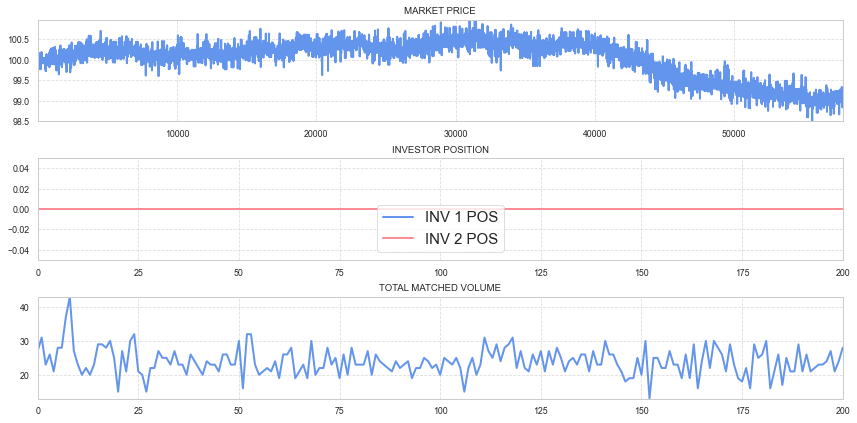

                                                         EPISODE 0 - 100%                                                                                                                                                                                                                                                                                                                                                                                EPISODE 0 - 84%                                                                                                                                                                                                                                                 EPISODE 0 - 87%                                                                                                                                                 EPISODE 0 - 88%                                                                                                                                

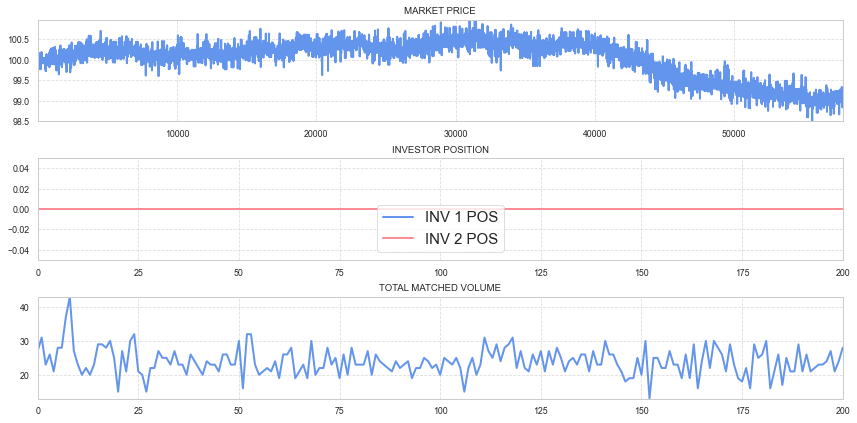

In [4]:
time_periods = 250
n_episodes = 1
rl_profit = []
market_prices = []
inv1_pos = []
inv2_pos = []
market_volume = []
atps = np.array([np.nan])
stack_autocorrels = True

save_count = 10
mm_volumes = np.zeros(int(time_periods / save_count))
random_volumes = np.zeros(int(time_periods / save_count))
investor_volumes = np.zeros(int(time_periods / save_count))
trend_volumes = np.zeros(int(time_periods / save_count))

mm_pnls = np.zeros(int(time_periods / save_count))
random_pnls = np.zeros(int(time_periods / save_count))
investor_pnls = np.zeros(int(time_periods / save_count))
trend_pnls = np.zeros(int(time_periods / save_count))

bps = []
sps = []

fig, ax = plt.subplots(3, 1, figsize = (12, 6))
fig.tight_layout()
for episode in range(n_episodes):
    env = MarketEnvironment(state0)
    # Initialize agents
    for j in range(n_agents):
            agents[j].reset()
            agents[j].update(state0)
            
    # START EPISODE
    for time in range(time_periods):

        agents, state = env.step(agents)

        for j in range(n_agents):
            agents[j].update(state)


        ########################################
        # PRINT RUNTIME
        ########################################

        j = (time + 1) / time_periods
        sys.stdout.write('\r'.center(65))
        sys.stdout.write(f"EPISODE {episode} - %d%%".center(65) % (100*j))
        sys.stdout.flush()
        
        #########################################
        # SAVE VOLUMES
        #########################################

        if save_count:
            
            if time % save_count == 0:
                for agent in agents:
                    agent.calculate_profit_and_loss(state)
                    if agent.agent_class == "MM":
                        mm_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        mm_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Random":
                        random_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        random_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Investor":
                        investor_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        investor_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Trend":
                        trend_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        trend_pnls[int(time / save_count)] += agent.pnl
            
        #########################################
        # UPDATE PLOTS
        #########################################

        inv1_pos.append(agents[0].position)
        inv2_pos.append(agents[1].position)
        market_volume.append(state["volume"])
        market_prices.append(state["market_prices"][-1])
        atps = np.hstack((atps, state["all_traded_prices"]))
        bps.append(agents[-1].buy_price)
        sps.append(agents[-1].sell_price)
        
        if time % 100 == 0:
            clear_output()
            ax[0].cla()
            #ax[0].plot(market_prices)
            ax[0].plot(atps)
            ax[0].set(title = "MARKET PRICE")

            ax[1].cla()
            ax[1].set(title = "INVESTOR POSITION")
            ax[1].plot(inv1_pos, label = "INV 1 POS")
            ax[1].plot(inv2_pos, label = "INV 2 POS")
            ax[1].legend()

            ax[2].cla()
            ax[2].set(title = "TOTAL MATCHED VOLUME")
            ax[2].plot(market_volume)

            display(fig)
    
    
    #########################################
    # END OF EPISODE
    #########################################
    if stack_autocorrels:
        mp = pd.DataFrame(atps)
        returns = (mp / mp.shift(1)  - 1).dropna()
        #fig1, ax1 = plt.subplots()
        #ax1.set(xlim = (0, 10))
        if episode == 0:
            # Stack returns
            all_stacked_returns = returns.values.flatten()
            # stack autocorrels
            #autocorrel_returns = pd.plotting.autocorrelation_plot(returns, ax = ax1).get_yticks()
            #autocorrel_absreturns = pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax1).get_yticks()
        else:
            # stack returns
            all_stacked_returns = np.hstack((all_stacked_returns, returns.values.flatten()))
            # stack autocorrels
            #temp_auto_returns = pd.plotting.autocorrelation_plot(returns, ax = ax1).get_yticks()
            #print("1", autocorrel_returns)
            #print("2", temp_auto_returns)
            #autocorrel_returns = np.vstack((autocorrel_returns, temp_auto_returns))
            #temp_auto_absreturns = pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax1).get_yticks()
            #autocorrel_absreturns = np.vstack((autocorrel_absreturns, temp_auto_absreturns))
       # ax1.cla()
    
    
    
mm_volumes[1:] = mm_volumes[1:] - mm_volumes[:-1]
random_volumes[1:] = random_volumes[1:] - random_volumes[:-1]
investor_volumes[1:] = investor_volumes[1:] - investor_volumes[:-1]
trend_volumes[1:] = trend_volumes[1:] - trend_volumes[:-1]
total_volumes = mm_volumes + investor_volumes + trend_volumes + random_volumes

mm_volumes = mm_volumes / total_volumes
investor_volumes = investor_volumes / total_volumes
trend_volumes = trend_volumes / total_volumes
random_volumes = random_volumes / total_volumes

stacked_volumes = np.vstack((random_volumes, investor_volumes, trend_volumes, mm_volumes))
stacked_pnls = np.vstack((random_pnls, investor_pnls, trend_pnls, mm_pnls))
time_points = np.linspace(save_count, time_periods, int(time_periods / save_count))

#save_state_space
#agents[n_agents - 1].save_state_space()

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Cumulative Return')]

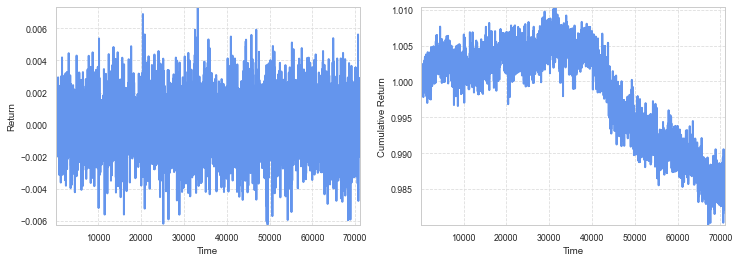

In [5]:
#mp = pd.DataFrame(market_prices[100:])
mp = pd.DataFrame(atps)

returns = (mp / mp.shift(1)  - 1).dropna()
#returns = returns[abs(returns.values) <= 0.0125]
cum_ret = (returns + 1).cumprod()
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(returns)
ax[0].set(ylabel = "Return", xlabel = "Time")
ax[1].plot(cum_ret)
ax[1].set(xlabel = "Time", ylabel = "Cumulative Return")

#plt.savefig("plots/returns_cumreturns_4.png")

# Stylized Facts Comparison

### Heavy Tails

In [6]:
all_stacked_returns.shape

(71105,)

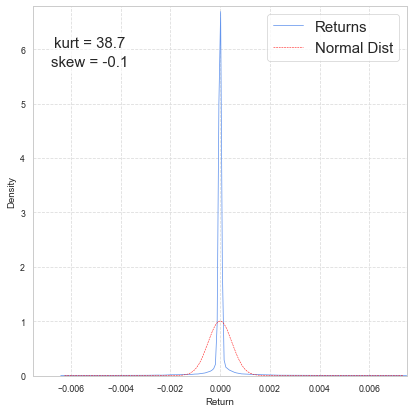

In [7]:
fig, ax = plt.subplots(figsize = (6, 6))
dist_vs_normal_plot(returns, ax = ax)
#dist_vs_normal(pd.DataFrame(all_stacked_returns), ax = ax)

fig.tight_layout()
#heavy_name = "heavy_tails_bfrl_4"
#plt.savefig(f"plots/{heavy_name}.png")

### Volatility Clustering

In [10]:
acf(abs(returns), nlags = 1)[1:]

array([0.23516323])

[(0.0, 41.0),
 (-0.25, 1.0),
 Text(0.5, 1.0, ''),
 Text(0.5, 14.7, 'Lag'),
 Text(19.575000000000003, 0.5, 'Autocorrelation')]

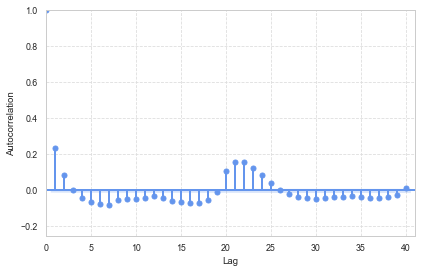

In [11]:
fig, ax = plt.subplots( figsize = (6, 4))
sm.graphics.tsa.plot_acf(np.abs(returns[1:]), lags = 40, ax = ax, alpha = 0.01)
fig.tight_layout()
ax.set(xlim = (0, 41), ylim = (-0.25, None), title = None, 
      xlabel = "Lag", ylabel = "Autocorrelation")
#vol_clust_name = "vol_cluster_bfrl_4"
#plt.savefig(f"plots/{vol_clust_name}.png")

### Autocorrel of returns

[(0.0, 41.0),
 (-0.25, 1.0),
 Text(0.5, 1.0, ''),
 Text(0.5, 14.7, 'Lag'),
 Text(19.575000000000003, 0.5, 'Autocorrelation')]

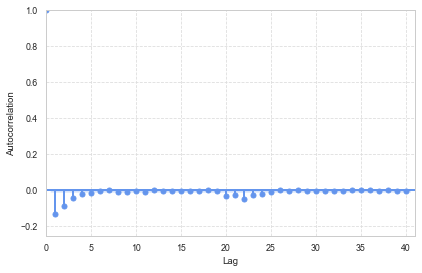

In [12]:
fig, ax = plt.subplots( figsize = (6, 4))
sm.graphics.tsa.plot_acf(returns[1:], lags = 40, ax = ax, alpha = 0.01)
fig.tight_layout()
ax.set(xlim = (0, 41), ylim = (-0.25, None), title = None, 
      xlabel = "Lag", ylabel = "Autocorrelation")
#vol_clust_name = "vol_cluster_bfrl_4"
#plt.savefig(f"plots/{vol_clust_name}.png")
#auto_ret_name = "auto_returns_bfrl_4"
#plt.savefig(f"plots/{auto_ret_name}.png")

# Volume Contribution

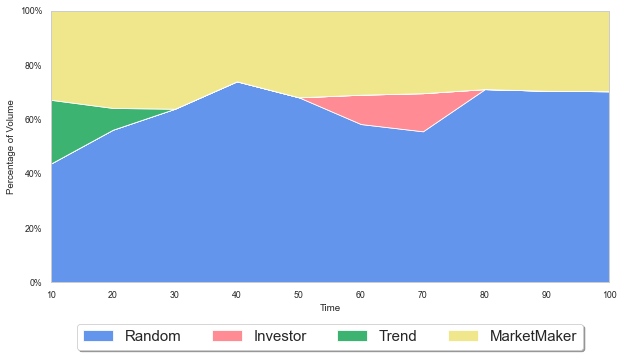

In [19]:
fig, ax = plt.subplots(figsize = (10, 5))
volume_contribution_plot(time_points, stacked_volumes, ax = ax)
#volume_name = "volume_graph_4"
#plt.savefig(f"plots/{volume_name}.png")

In [35]:
len(time_points)

100

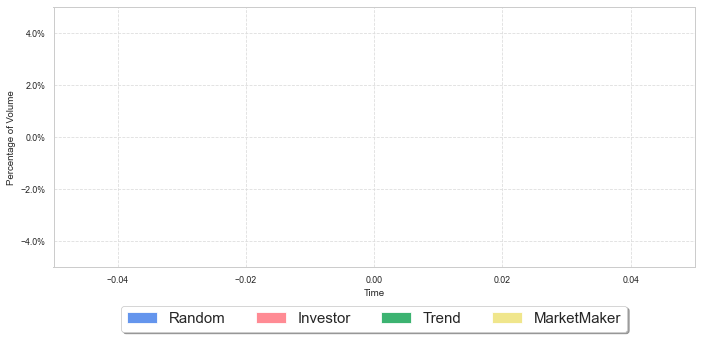

In [20]:
fig, ax = plt.subplots(figsize = (10, 5))
volume_contribution_plot(time_points[50:80], stacked_volumes[:, 50:80], ax = ax)
fig.tight_layout()
#volume_name_zoom = "volume_graph_zoom_4"
#plt.savefig(f"plots/{volume_name_zoom}.png")

## Test MMS

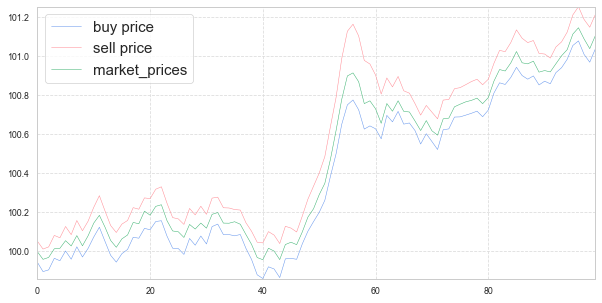

In [21]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(bps, label = "buy price", lw = 0.5)
ax.plot(sps, label = "sell price", lw = 0.5)
ax.plot(state["market_prices"][100:], label = "market_prices", lw = 0.5)
ax.legend()
#ax.set_xlim(200, 250)
#ax.set_ylim(108, 110)

<AxesSubplot:>

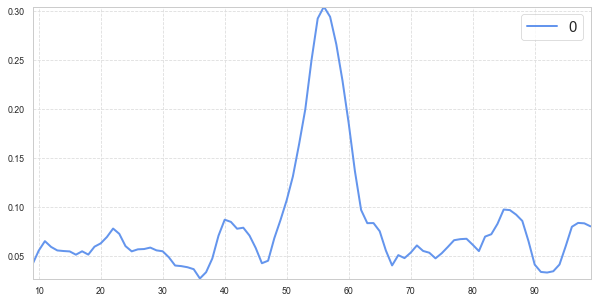

In [22]:
fig, ax = plt.subplots(figsize = (10, 5))
pd.DataFrame(state["market_prices"][100:]).rolling(window = 10).std().plot(ax = ax)

# PnL

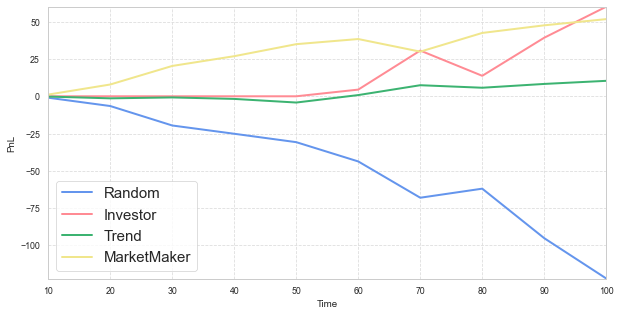

In [23]:
fig, ax = plt.subplots(figsize = (10, 5))
labs = ["Random", "Investor", "Trend", "MarketMaker"]
for j in range(4):
    ax.plot(time_points, stacked_pnls[j, :], label = labs[j])
ax.set(xlabel = "Time", ylabel = "PnL")
ax.legend()

# Performance overview

In [45]:
stats_df = pd.DataFrame({"id":None, "class":None, "Position":None, "PNL":None}, index = [0]).dropna()
for agent in agents:
    agent.calculate_profit_and_loss(state)
    df_temp = pd.DataFrame({"id": agent.agent_id,
                            "class":agent.agent_class, 
                            "Position":agent.position, 
                            "PNL": agent.pnl, 
                            "latency": agent.latency},
                            index = [agent.agent_id])
    stats_df = stats_df.append(df_temp)

print("PNL SUM: ", stats_df["PNL"].sum())
print("POS SUM: ", stats_df["Position"].sum())
stats_df.sort_values("latency", inplace = True)
np.corrcoef(stats_df.PNL.values, stats_df.latency.values)
display(stats_df)
display(stats_df.groupby("class")["PNL"].mean())

PNL SUM:  -5.343281372915953e-12
POS SUM:  0.0


,id,class,Position,PNL,latency
30,30,MM,3.0,-68.539122,0.508333
35,35,MM,3.0,-109.818973,0.534366
43,43,MM,4.0,-53.154131,0.542505
31,31,MM,4.0,-89.231790,0.543184
27,27,MM,3.0,-25.412543,0.549776
28,28,MM,2.0,-76.138978,0.589769
44,44,MM,5.0,-94.919661,0.626480
37,37,MM,2.0,-106.911924,0.629812
26,26,MM,4.0,-90.689244,0.686926
42,42,MM,2.0,-111.020548,0.716290


class
Investor    521.838246
MM          -77.589594
Random       19.759788
Trend        37.639876
Name: PNL, dtype: float64